In [1]:
import os
import re
import heapq
import sklearn
import warnings
import numpy as np
import pandas as pd
from heapq import heappop
from heapq import heappush
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from IPython.display import display
from sklearn.metrics.pairwise import cosine_distances
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# HIDE WARNINGS
warnings.filterwarnings("ignore")

#### Create data set

Scan all news directories and read all '.txt' files.

In [2]:
path = "./news_data"
ids = list()
titles = list()
contents = list()
categories = list()
# FOR ALL DIRECTORIES
for directory in os.listdir(path):
    if os.path.isdir(f"{path}/{directory}/"):
        # FOR FILES IN EACH DIRECTORY
        for file in os.listdir(f"{path}/{directory}/"):
            if file.endswith(".txt"):
                ids.append(len(ids)+1)
                f = open(f"{path}/{directory}/{file}")
                lines = f.readlines()
                titles.append(lines[0][:-1])
                content = ""
                for line in lines[1:]:
                    content = content + " " + line[:-1]
                contents.append(content)
                categories.append(directory)
# CREATE DATAFRAME
data_set = pd.DataFrame(columns=["id","title","content","category"])
data_set["id"] = ids
data_set["title"] = titles
data_set["content"] = contents
data_set["category"] = categories
# ASSOCIATE CATEGORY NAMES WITH NUMERICAL INDEX
data_set["category_id"] = data_set["category"].factorize()[0]
display(data_set)
# CREATE data_set.csv
data_set.to_csv("./data_sets/data_set.csv",sep="\t",index=False)

,id,title,content,category,category_id
0,1,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarn...,business,0
1,2,Dollar gains on Greenspan speech,The dollar has hit its highest level against...,business,0
2,3,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yu...,business,0
3,4,High fuel prices hit BA's profits,British Airways has blamed high fuel prices ...,business,0
4,5,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dom...,business,0
...,...,...,...,...,...
2220,2221,BT program to beat dialler scams,BT is introducing two initiatives to help be...,tech,4
2221,2222,Spam e-mails tempt net shoppers,Computer users across the world continue to ...,tech,4
2222,2223,Be careful how you code,A new European directive could put software ...,tech,4
2223,2224,US cyber security chief resigns,The man making sure US computer networks are...,tech,4


#### Display five random samples

In [3]:
data_set.sample(5, random_state=0)

,id,title,content,category,category_id
384,385,Tate & Lyle boss bags top award,Tate & Lyle's chief executive has been named...,business,0
1983,1984,Halo 2 sells five million copies,Microsoft is celebrating bumper sales of its...,tech,4
985,986,MSPs hear renewed climate warning,Climate change could be completely out of co...,politics,2
1386,1387,Pavey focuses on indoor success,Jo Pavey will miss January's View From Great...,sport,3
1294,1295,Tories reject rethink on axed MP,Sacked MP Howard Flight's local Conservative...,politics,2


#### Distribution of each category

category
business         510
entertainment    386
politics         417
sport            511
tech             401
Name: category_id, dtype: int64

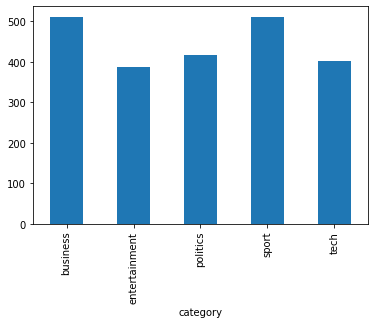

In [4]:
display(data_set.groupby("category").category_id.count())
display(data_set.groupby("category").category_id.count().plot.bar())

#### Create train set and test set

Split data set and create train and test set.

In [5]:
X = data_set.iloc[:,:-1].values
y = data_set.iloc[:,-1].values

# SPLIT DATA SET
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

# CREATE TRAIN DATAFRAME
train_set = pd.DataFrame(X_train,columns=["id","title","content","category"])
train_set["category_id"] = pd.DataFrame(y_train,columns=["category_id"])
display(train_set)
# CREATE TEST DATAFRAME
test_set = pd.DataFrame(X_test,columns=["id","title","content","category"])
test_set["category_id"] = pd.DataFrame(y_test,columns=["category_id"])
display(test_set)

# MAKE SURE THAT TRAIN SET AND TEST SET HAVE A GOOD SPLIT
# DISPLAY NUMBER OF CATEGORIES FOR TRAIN SET
train_category = train_set.groupby("category").id.count()
train_category = train_category.reset_index()
train_category = train_category.rename(columns={"id":"number_of_categories"})
display(train_category.shape,train_category)
# DISPLAY NUMBER OF CATEGORIES FOR TEST SET
test_category = test_set.groupby("category").id.count()
test_category = test_category.reset_index()
test_category = test_category.rename(columns={"id":"number_of_categories"})
display(test_category.shape,test_category)
# CREATE train_set.csv AND test_set.csv
train_set.to_csv("./data_sets/train_set.csv",sep="\t",index=False,columns=["id","title","content","category"])
test_set.to_csv("./data_sets/test_set.csv",sep="\t",index=False,columns=["id","title","content"])

,id,title,content,category,category_id
0,842,Incredibles win animation awards,The Incredibles movie has beaten Shrek 2 to ...,entertainment,1
1,1749,Hantuchova in Dubai last eight,Daniela Hantuchova moved into the quarter-fi...,sport,3
2,2119,More power to the people says HP,The digital revolution is focused on letting...,tech,4
3,1175,Amnesty chief laments war failure,The lack of public outrage about the war on ...,politics,2
4,1503,SA return to Mauritius,Top seeds South Africa return to the scene o...,sport,3
...,...,...,...,...,...
1775,1034,EU fraud clampdown urged,EU member states are failing to report fraud...,politics,2
1776,1732,Tindall aiming to earn Lions spot,Bath and England centre Mike Tindall believe...,sport,3
1777,764,Jamelia's return to the top,R&B star Jamelia had three Brit nominations ...,entertainment,1
1778,836,Oscars steer clear of controversy,The Oscars nominations list has left out som...,entertainment,1


,id,title,content,category,category_id
0,385,Tate & Lyle boss bags top award,Tate & Lyle's chief executive has been named...,business,0
1,1984,Halo 2 sells five million copies,Microsoft is celebrating bumper sales of its...,tech,4
2,986,MSPs hear renewed climate warning,Climate change could be completely out of co...,politics,2
3,1387,Pavey focuses on indoor success,Jo Pavey will miss January's View From Great...,sport,3
4,1295,Tories reject rethink on axed MP,Sacked MP Howard Flight's local Conservative...,politics,2
...,...,...,...,...,...
440,439,German economy rebounds,"Germany's economy, the biggest among the 12 ...",business,0
441,300,J&J agrees $25bn Guidant deal,Pharmaceutical giant Johnson & Johnson has a...,business,0
442,1286,Child access law shake-up planned,Parents who refuse to allow former partners ...,politics,2
443,1506,Real in talks over Gravesen move,Real Madrid are closing in on a Β£2m deal fo...,sport,3


(5, 2)

,category,number_of_categories
0,business,399
1,entertainment,312
2,politics,331
3,sport,403
4,tech,335


(5, 2)

,category,number_of_categories
0,business,111
1,entertainment,74
2,politics,86
3,sport,108
4,tech,66
